In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# 1. Load data
df = pd.read_csv("dividends_data.csv")
df["Year"]   = df["Year"].astype(int)
df["Actual"] = pd.to_numeric(df["Actual"], errors="coerce").fillna(0)
df["Actual"] = df["Actual"] * 100

# 2. Fill missing years per ticker
filled = []
for ticker, grp in df.groupby("Ticker"):
    years = np.arange(grp["Year"].min(), grp["Year"].max() + 1)
    tmp   = pd.DataFrame({"Year": years})
    tmp   = tmp.merge(grp[["Year", "Actual"]], on="Year", how="left").fillna(0)
    tmp["Ticker"] = ticker
    filled.append(tmp)
df_full = pd.concat(filled, ignore_index=True)

# 3. Log‐transform dividends: lDPS = log(1 + Actual)
df_full["lDPS"] = np.log1p(df_full["Actual"])

# 4. Rolling‐window ARIMA forecasts per ticker
WINDOW = 10
ORDER  = (1, 1, 2)
rows   = []

for ticker, grp in df_full.groupby("Ticker"):
    grp = grp.sort_values("Year").reset_index(drop=True)
    if len(grp) <= WINDOW:
        continue

    for idx in range(WINDOW, len(grp)):
        train   = grp.loc[idx-WINDOW:idx-1, "lDPS"]
        year    = grp.loc[idx, "Year"]
        actual  = grp.loc[idx, "Actual"]

        try:
            model  = ARIMA(train, order=ORDER)
            fit    = model.fit(method_kwargs={"warn_convergence": False})
            pred_l = fit.forecast(steps=1).iloc[0]     # positional access
            forecast = np.expm1(pred_l)
        except Exception:
            forecast = np.nan

        rows.append({
            "Ticker":   ticker,
            "Year":     year,
            "Actual":   actual,
            "Forecast": forecast,
            "Error":    (forecast - actual) if pd.notna(forecast) else np.nan
        })

# 5. Build results DataFrame and save
results = pd.DataFrame(rows, columns=["Ticker","Year","Actual","Forecast","Error"])
print(results.head())

results.to_csv("arima_rolling_by_ticker.csv", index=False)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters f

   Ticker  Year  Actual    Forecast       Error
0  ABI BB  2016   360.0   73.503571 -286.496429
1  ABI BB  2017   360.0   60.219399 -299.780601
2  ABI BB  2018   280.0  263.537847  -16.462153
3  ABI BB  2019   180.0  307.671221  127.671221
4  ABI BB  2020    50.0  114.825362   64.825362


In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Load data
df = pd.read_csv("dividends_data.csv")
df["Year"]   = df["Year"].astype(int)
df["Actual"] = pd.to_numeric(df["Actual"], errors="coerce").fillna(0)
df["Actual"] = df["Actual"] * 100  # scale if desired

# 2. Fill missing years per ticker
filled = []
for ticker, grp in df.groupby("Ticker"):
    years = np.arange(grp["Year"].min(), grp["Year"].max() + 1)
    tmp   = pd.DataFrame({"Year": years})
    tmp   = tmp.merge(grp[["Year", "Actual"]], on="Year", how="left").fillna(0)
    tmp["Ticker"] = ticker
    filled.append(tmp)
df_full = pd.concat(filled, ignore_index=True)

# 3. Log‐transform dividends: lDPS = log(1 + Actual)
df_full["lDPS"] = np.log1p(df_full["Actual"])

# 4. Rolling‐window ARIMA forecasts per ticker
WINDOW = 10
ORDER  = (1, 1, 0)
rows   = []

for ticker, grp in df_full.groupby("Ticker"):
    grp = grp.sort_values("Year").reset_index(drop=True)
    if len(grp) <= WINDOW:
        continue

    for idx in range(WINDOW, len(grp)):
        train   = grp.loc[idx-WINDOW:idx-1, "lDPS"]
        year    = grp.loc[idx, "Year"]
        actual  = grp.loc[idx, "Actual"]

        try:
            model  = ARIMA(train, order=ORDER)
            fit    = model.fit(method_kwargs={"warn_convergence": False})
            pred_l = fit.forecast(steps=1).iloc[0]
            forecast = np.expm1(pred_l)
        except Exception:
            forecast = np.nan

        rows.append({
            "Ticker":   ticker,
            "Year":     year,
            "Actual":   actual,
            "Forecast": forecast,
        })

# 5. Build results DataFrame
results = pd.DataFrame(rows, columns=["Ticker","Year","Actual","Forecast"])
results["Error"] = results["Forecast"] - results["Actual"]
results["Absolute_Error"] = results["Error"].abs()
results["APE"] = np.where(
    results["Actual"] != 0,
    results["Absolute_Error"] / results["Actual"],
    np.nan
)

# 6. Compute evaluation metrics per ticker
metrics = []
for ticker, grp in results.groupby("Ticker"):
    grp = grp.dropna(subset=["Forecast"])  # remove NaN forecasts
    if grp.empty:
        continue

    y_true = grp["Actual"]
    y_pred = grp["Forecast"]

    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.nanmean(grp["APE"]) * 100  # in percent

    metrics.append({
        "Ticker":   ticker,
        "MAE":      mae,
        "RMSE":     rmse,
        "MAPE(%)":  mape,
        "Horizon": 1,
        "Window":  WINDOW
    })

metrics_df = pd.DataFrame(metrics)

# 7. Overall metrics
overall = metrics_df.drop(columns=["Ticker"]).mean(numeric_only=True).to_dict()
overall["Ticker"]  = "Overall"
overall["Horizon"] = 1
overall["Window"]  = WINDOW
overall_df = pd.DataFrame([overall])

# 8. Print and save
print("Per-ticker evaluation:")
print(metrics_df)
print("\nOverall evaluation:")
print(overall_df)

results.to_csv("arima_rolling_by_ticker.csv", index=False)
pd.concat([metrics_df, overall_df], ignore_index=True) \
  .to_csv("arima_evaluation_metrics.csv", index=False)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: 

Per-ticker evaluation:
      Ticker         MAE        RMSE     MAPE(%)  Horizon  Window
0     ABI BB   55.643417   79.686375   64.583292        1      10
1      AD NA   35.845653   47.085640   38.697352        1      10
2     ADS GY  160.486240  201.082597   88.264866        1      10
3      AI FP    7.773430    9.835178    2.657594        1      10
4     AIR FP   57.071298   78.158755   28.891695        1      10
5     ALV GY   98.712854  112.778516   10.222591        1      10
6    ASML NA  130.487356  167.919764   33.377390        1      10
7     BAS GY   22.904805   38.721321    8.721871        1      10
8    BAYN GY   49.873040   81.925055  249.103111        1      10
9    BBVA SQ   13.035418   15.776770   41.165342        1      10
10    BMW GY  174.412229  228.572353   37.623051        1      10
11     BN FP   10.298934   12.637674    5.455109        1      10
12    BNP FP  130.863478  172.768051   34.744388        1      10
13     CS FP   23.392454   27.216497   19.475752     

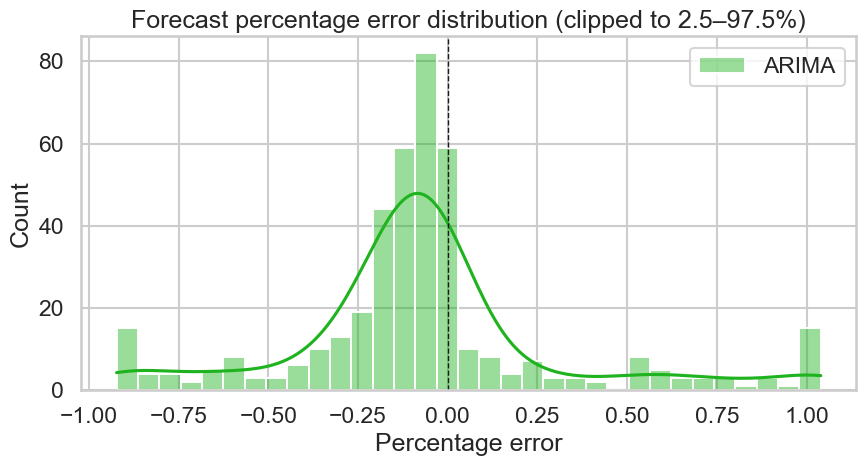

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Copy and compute again just in case
df = results.dropna().copy()
df["ARIMA % Error"] = df["Forecast"]/df["Actual"] - 1

# Winsorize to the 2.5th–97.5th percentile for plotting
lo, hi = np.percentile(df["ARIMA % Error"].values.flatten(), [2.5, 97.5])
df_plot = df.copy()
df_plot["ARIMA % Error"] = df["ARIMA % Error"].clip(lo, hi)

# Plot
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(9,5))

sns.histplot(df_plot["ARIMA % Error"], bins=33, kde=True, color="#1fb41f",
             alpha=0.45, label="ARIMA")

plt.axvline(0, color="k", lw=1, ls="--")
plt.xlabel("Percentage error")
plt.ylabel("Count")
plt.title("Forecast percentage error distribution (clipped to 2.5–97.5%)")
plt.legend()
plt.tight_layout()
plt.show()